# Analyzing Empirical Data for Comparison Between node2vec Implementations
### Agustin Lorenzo, Jonathan Sanderford




## Introduction
### node2vec
*node2vec* is a semi-supervised algorithm for scalable feature learning of networks. Previous methods employed supervised machine learning, but this required expert knowledge to hand-engineer features and results were not generalizable. Other attempts at unsupervised learning came to difficulties with defining and optimizing an objective function. As for sampling strategies, two extreme classical approaches employed `BFS` and `DFS`, but each came with their advantages and disadvantages. *node2vec*'s key contribution comes from its utilization of biased random walks to explore neighborhoods in both a `BFS` and `DFS` fashion.
### PecanPy
*node2vec* provides a great start in solving the original problem of unsupervised feature learning of networks, but it has still left room for improvement and optimization. Since its creation, a number of subsequent implementations have claimed to improve upon the efficacy of the original implementation in Python and C++. Most notably, *PecanPy* is a popular implementation of the *node2vec* algorithm that claims to improve both the time and space complexity.
### Project goals
We hope to expand upon the original paper proposing the *node2vec* algorithm, *node2vec: Scalable Feature Learning for Networks*, by evaluating if one subsequent implementation has improved upon the original. Specifically, we will be analyzing the time complexity of the two algorithms. We will make use of both the original *node2vec* algorithm along with the *PecanPy* implementation to gather empirical data on the time required for learning from each algorithms. With this data we will analyze the difference between the two implementations through a one-sided t-test.
#### Hypothesies ($\alpha = 0.05$)
> $H_0:$ There is no difference between the time's required for learning from both the original *node2vec* algorithm and the *PecanPy* implementation. <br>
> $H_a:$ The time required for learning for the *PecanPy* implementation is lower than the time required for the original *node2vec* algorithm.

In [6]:
# Importing all required packages
import time
import csv
import pecanpy
import os
import linecache
import tracemalloc
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from node2vec import Node2Vec
from pecanpy import pecanpy
from pecanpy.graph import AdjlstGraph
from pecanpy.graph import SparseGraph
from memory_profiler import memory_usage

## Example of measuring time and storage use for *node2vec*
Here, we will find the time elapsed (in seconds) and storage used (in megabytes) for the original *node2vec* implementation. This is one simple example using a small synthetic network.

### Measuring time
We will create a graph containing 100 nodes, with the probably of any two nodes being connected equal to $0.1$, and record times before and after running the *node2vec* algorithm. Subtracting the final time from the inital time will give us the total elapsed time. 

Graph with 100 nodes and 472 edges


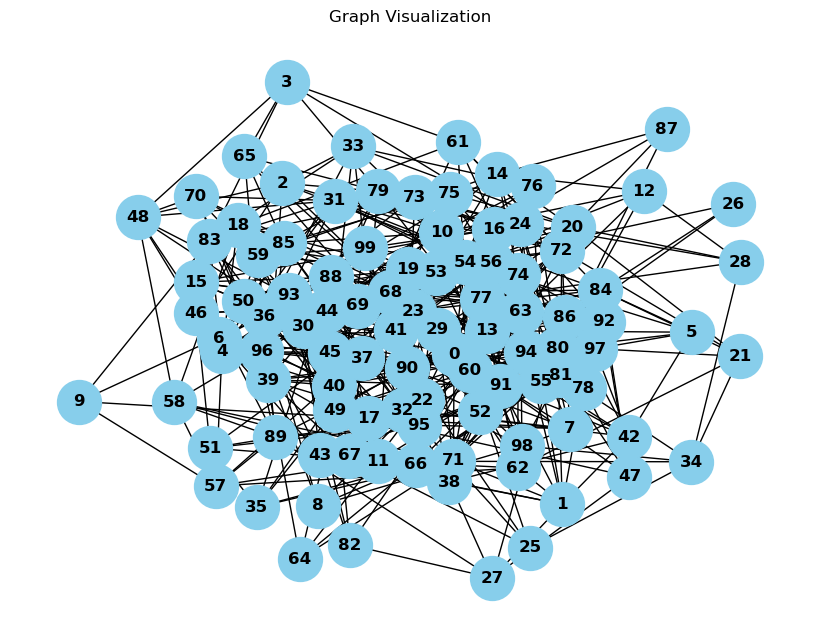

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 78.36it/s]





Elapsed time for node2vec:	41.08 seconds


In [11]:
# Random synthetic network
G = nx.fast_gnp_random_graph(n=100, p=0.1)
print(G)
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold')
plt.title("Graph Visualization")
plt.show()

#  Measure time for unsupervised node2vec training, including both random walk generation and actual learning
start_time = time.time() # begin time measurement

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
node2vec.fit(window=10, min_count=1, batch_words=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

elapsed_time = time.time() - start_time # end time measurement


print("\n\n")
print("Elapsed time for node2vec:\t{:.2f} seconds".format(elapsed_time))

### Measuring storage
Here we will use `tracemalloc` to measure how much storage is used during the node2vec algorithm. `tracemalloc` allows for use of a "snapshot" which contains information about the memory usage for all processes after `tracemalloc.start()` is called. By summing up all provided values, we can measure the total used memory for the *node2vec* algorithm. 

Graph with 100 nodes and 512 edges


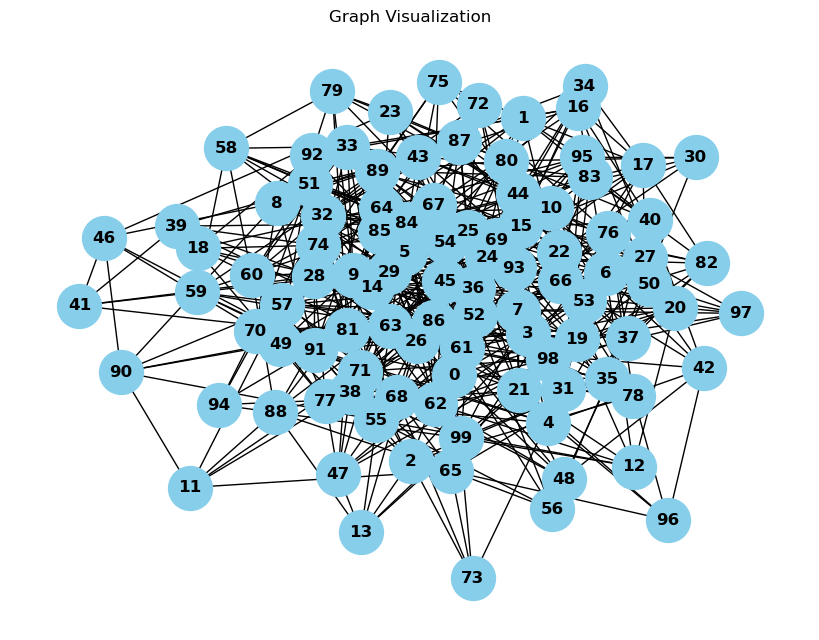

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 81.14it/s]


Total memory used: 75.79 MB


In [12]:
import os
import linecache
import tracemalloc

# using a similar graph as before
G = nx.fast_gnp_random_graph(n=100, p=0.1)
print(G)
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, font_size=12, font_weight='bold')
plt.title("Graph Visualization")
plt.show()


tracemalloc.start() # begin measuring memory usage
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
node2vec.fit(window=10, min_count=1, batch_words=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
snapshot = tracemalloc.take_snapshot() # end memory measurement

# Summing every process's memory usage to get total memory
total_size = sum(stat.size for stat in snapshot.statistics('lineno'))

# Converting the total size from bytes to megabytes
total_size_mb = total_size / (1024**2)

print("\n\n")
print(f"Total memory used: {total_size_mb:.2f} MB")


## Generating data
To compare the time and space complexities between *node2vec* and *PecanPy* empirically, we will need to generate enough instances for a significant comparison. This data will be saved to a separate file for further analysis. We will generate 100 small, sparse graphs with 10 nodes each and run both the original *node2vec* and newer *PecanPy* implementations over each of them. The runtimes and memory usages for each of the learning algorithms will be recorded and saved onto a .csv file.
### PecanPy modes
There are a number of modes available for *PecanPy*, with each optimized for different types of networks. The three main modes are `PreComp`, `SparseOTF`, and `DenseOTF`. The creators of *PecanPy* provide the following table to specify the use cases for each: <br>
![PECANPY MODES](pecanpy_table.png) <br>
Because `PreCompFirstOrder` and `FirstOrderUnweighted` were created for specific edgecases, they will not be considered in our analysis. 

### Helper functions

In [20]:
# Helper function for running original node2vec implementation and PecanPy implementations
# and recording elapsed time and memory usage
def measure_algorithm(algorithm, G):
    walks=None
    # Determining which algorithm is being measured,
    # creating the appropriate graph for the algorithm
    if algorithm == "node2vec":
        node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    else:
        g = AdjlstGraph()
        for node in G.nodes():
            g.add_node(node)
        for edge in G.edges():
            g.add_edge(str(edge[0]), str(edge[1]))
        g.save('currentnet.edg')
        if algorithm == "precomp":
            g = pecanpy.PreComp(workers=4, verbose=False)
        elif algorithm == "sparseotf":
            g = pecanpy.SparseOTF(workers=4, verbose=False)
        elif algorithm == "denseotf":
            g = pecanpy.DenseOTF(workers=4, verbose=False)
            g.read_edg("currentnet.edg", weighted=False, directed=False)
            g.preprocess_transition_probs()
            walks = g.simulate_walks(num_walks=200, walk_length=30) 

    # Beginning measurements
    tracemalloc.clear_traces() # reset memory 
    start_time = time.time() # begin time
    tracemalloc.start() # begin measuring memory usage

    # Beginning training
    if algorithm == "node2vec":
        node2vec.fit(window=10, min_count=1, batch_words=4)
    else:
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)

    # Ending measurements
    current, peak = tracemalloc.get_traced_memory() # end memory
    tracemalloc.clear_traces() # reset memory 
    elapsed_time = time.time() - start_time # end time
    memory_usage = peak / (1024**2)

    # Returning results
    print(algorithm + "\n---------\n" + "Elapsed time: {:.3f} seconds".format(elapsed_time))
    print(f"Memory usage: {memory_usage:.3f} MB")
    print("\n\n")
    return elapsed_time, memory_usage

In [23]:
# Another helper function for generating data,
# uses measure_algorithm to obtain elapsed time and memory usage for an algorithm
def generate_data(filename, n, p, datasize):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["node2vec_time", "node2vec_memory", "precomp_time", "precomp_memory", "SparseOTF_time", "SparseOTF_memory" "DenseOTF_time", "DenseOTF_memory"])
        
        for i in range(datasize):
            G = nx.fast_gnp_random_graph(n=n, p=p)
            nx.write_edgelist(G, "currentnet.edgelist")

            n2v_time, n2v_memory = measure_algorithm("node2vec", G)
            precomp_time, precomp_memory = measure_algorithm("precomp", G)
            sparseotf_time, sparseotf_memory = measure_algorithm("sparseotf", G)
            denseotf_time, denseotf_memory = measure_algorithm("denseotf", G)
        
            writer.writerow([n2v_time, n2v_memory, precomp_time, precomp_memory, sparseotf_time, sparseotf_memory, denseotf_time, denseotf_memory])
        

In [ ]:
# OLD CODE; REMOVE FROM FINAL SUBMISSION
from pecanpy import pecanpy

with open('small_sparse.csv','w', newline='') as csvfile:
    # Begin writing onto the csv file
    writer = csv.writer(csvfile)
    writer.writerow(["node2vec_time", "node2vec_memory", "precomp_time", "precomp_memory", "SparseOTF_time", "SparseOTF_memory" "DenseOTF_time", "DenseOTF_memory"])

    # Run node2vec and PecanPy algorithms n times each on similar randomly generated graphs (of a given size) and record elapsed times to csv file
    for i in range(100):
        # Synthesize small and sparse graph
        G = nx.fast_gnp_random_graph(n=10, p=0.1)
        nx.write_edgelist(G, "currentnet.edgelist")

        # Running original node2vec implementation and recording elapsed time and memory usage
        node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
        start_time = time.time() # begin time for training with original node2vec implementation
        tracemalloc.start() # begin measuring memory usage
        node2vec.fit(window=10, min_count=1, batch_words=4)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        n2v_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        n2v_memory = total_size / (1024**2)
        print("node2vec total time elapsed: {:.3f} seconds".format(n2v_time))
        print(f"Total memory used: {n2v_memory:.2f} MB")
        print("\n\n")

        # Running all PecanPy implementations and recording elapsed time and memory usage
        # Convert current graph for use with PecanPy
        g = AdjlstGraph()
        for node in G.nodes():
            g.add_node(node)
        for edge in G.edges():
            g.add_edge(str(edge[0]), str(edge[1]))
        g.save('currentnet.edg')

        # PecanPy PreComp implementation
        g = pecanpy.PreComp(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()
        walks = g.simulate_walks(num_walks=200, walk_length=30)           
        
        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        precomp_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        precomp_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(precomp_time))
        print(f"Total memory used: {precomp_memory:.2f} MB")
        print("\n\n")

        #PecanPy SparseOTF implementation
        g = pecanpy.SparseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        sparseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        sparseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(sparseotf_time))
        print(f"Total memory used: {sparseotf_memory:.2f} MB")
        print("\n\n")

        g = pecanpy.DenseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        denseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        denseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(denseotf_time))
        print(f"Total memory used: {denseotf_memory:.2f} MB")
        print("\n\n")

        writer.writerow([n2v_time, n2v_memory, precomp_time, precomp_memory, sparseotf_time, sparseotf_memory, denseotf_time, denseotf_memory])

### Small and sparse graphs
The first use case is for "small and sparse" graphs. With that in mind, we will create synthetic networks containing 10 nodes with a probability of 0.1 for edge creation. 

In [ ]:
generate_data('small_sparse.csv', 10, 0.1, 100)

### Large and Sparse Graphs
The next use case is "large and sparse" graphs, which the authors of *PecanPy* claim to be most appropriate for the `SparseOTF` implementation. Here, we will generate synthetic graphs with 100 nodes and a probability of 0.05 for edge creation, which can be considered sparse for its size. 

In [26]:
generate_data('large_sparse.csv', 100, 0.05, 100)

Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:00<00:00, 86.92it/s]


node2vec
---------
Total time elapsed: 17.096 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.517 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 51.81it/s]


node2vec
---------
Total time elapsed: 20.670 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.326 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 106.68it/s]


node2vec
---------
Total time elapsed: 15.892 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.194 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 101.19it/s]


node2vec
---------
Total time elapsed: 20.224 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 7.086 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:01<00:00, 44.38it/s]


node2vec
---------
Total time elapsed: 21.627 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.239 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 90.97it/s]


node2vec
---------
Total time elapsed: 19.854 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.006 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.948 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 52.60it/s]


node2vec
---------
Total time elapsed: 20.129 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.211 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 105.04it/s]


node2vec
---------
Total time elapsed: 16.057 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.211 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:02<00:00, 18.56it/s]


node2vec
---------
Total time elapsed: 16.611 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.298 seconds
Memory usage: 0.21 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 100.88it/s]


node2vec
---------
Total time elapsed: 16.672 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.005 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.275 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 109.77it/s]


node2vec
---------
Total time elapsed: 16.362 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.233 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 112.34it/s]


node2vec
---------
Total time elapsed: 17.955 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.191 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 108.55it/s]


node2vec
---------
Total time elapsed: 15.617 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.206 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 108.17it/s]


node2vec
---------
Total time elapsed: 15.783 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.238 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 74.46it/s]


node2vec
---------
Total time elapsed: 21.495 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.334 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 76.02it/s]


node2vec
---------
Total time elapsed: 16.191 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.226 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 105.10it/s]


node2vec
---------
Total time elapsed: 15.782 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.228 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 105.56it/s]


node2vec
---------
Total time elapsed: 16.027 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.206 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 97.95it/s]


node2vec
---------
Total time elapsed: 17.853 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.211 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 110.71it/s]


node2vec
---------
Total time elapsed: 15.610 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.208 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 102.10it/s]


node2vec
---------
Total time elapsed: 15.724 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.224 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 95.70it/s]


node2vec
---------
Total time elapsed: 18.932 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.247 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 98.46it/s]


node2vec
---------
Total time elapsed: 17.435 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.224 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 112.05it/s]


node2vec
---------
Total time elapsed: 16.179 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.196 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 100.59it/s]


node2vec
---------
Total time elapsed: 17.696 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.479 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 87.86it/s]


node2vec
---------
Total time elapsed: 17.524 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.211 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 106.44it/s]


node2vec
---------
Total time elapsed: 17.230 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.207 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 94.24it/s]


node2vec
---------
Total time elapsed: 19.731 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.198 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 82.93it/s] 


node2vec
---------
Total time elapsed: 17.139 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.345 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 80.55it/s]


node2vec
---------
Total time elapsed: 17.695 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.235 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 71.48it/s]


node2vec
---------
Total time elapsed: 16.865 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.023 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.288 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 105.74it/s]


node2vec
---------
Total time elapsed: 19.038 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.605 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 53.22it/s]


node2vec
---------
Total time elapsed: 23.890 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.280 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 87.73it/s]


node2vec
---------
Total time elapsed: 16.697 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.219 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 111.17it/s]


node2vec
---------
Total time elapsed: 15.542 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.584 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 92.12it/s]


node2vec
---------
Total time elapsed: 18.164 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.192 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 108.27it/s]


node2vec
---------
Total time elapsed: 16.786 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.282 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 109.87it/s]


node2vec
---------
Total time elapsed: 16.173 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.208 seconds
Memory usage: 0.12 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 99.03it/s] 


node2vec
---------
Total time elapsed: 17.859 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.375 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 61.51it/s]


node2vec
---------
Total time elapsed: 21.438 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.246 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 106.43it/s]


node2vec
---------
Total time elapsed: 16.361 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.534 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 66.65it/s]


node2vec
---------
Total time elapsed: 21.689 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.281 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 96.68it/s] 


node2vec
---------
Total time elapsed: 23.660 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.005 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.291 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 91.35it/s]


node2vec
---------
Total time elapsed: 18.995 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.177 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 82.80it/s] 


node2vec
---------
Total time elapsed: 15.792 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.329 seconds
Memory usage: 0.17 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 84.06it/s]


node2vec
---------
Total time elapsed: 16.041 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.358 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 77.14it/s]


node2vec
---------
Total time elapsed: 18.042 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.224 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 96.91it/s] 


node2vec
---------
Total time elapsed: 16.876 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.608 seconds
Memory usage: 0.21 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 69.62it/s]


node2vec
---------
Total time elapsed: 20.708 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 2.052 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 59.45it/s]


node2vec
---------
Total time elapsed: 27.672 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.332 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 101.86it/s]


node2vec
---------
Total time elapsed: 15.367 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.209 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 109.00it/s]


node2vec
---------
Total time elapsed: 15.895 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.208 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 81.86it/s]


node2vec
---------
Total time elapsed: 15.582 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.210 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 67.31it/s]


node2vec
---------
Total time elapsed: 15.943 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.217 seconds
Memory usage: 0.17 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 91.90it/s]


node2vec
---------
Total time elapsed: 17.184 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.195 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 107.94it/s]


node2vec
---------
Total time elapsed: 15.802 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.005 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.205 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 113.90it/s]


node2vec
---------
Total time elapsed: 17.573 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.187 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 109.98it/s]


node2vec
---------
Total time elapsed: 15.795 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.203 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 116.22it/s]


node2vec
---------
Total time elapsed: 15.329 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.164 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 107.10it/s]


node2vec
---------
Total time elapsed: 15.959 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.177 seconds
Memory usage: 0.17 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 106.10it/s]


node2vec
---------
Total time elapsed: 17.513 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.193 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 104.19it/s]


node2vec
---------
Total time elapsed: 15.541 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.182 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 113.54it/s]


node2vec
---------
Total time elapsed: 15.634 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.214 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 114.68it/s]


node2vec
---------
Total time elapsed: 16.652 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.227 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 105.24it/s]


node2vec
---------
Total time elapsed: 15.548 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.169 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 111.40it/s]


node2vec
---------
Total time elapsed: 15.271 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.197 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 107.86it/s]


node2vec
---------
Total time elapsed: 15.369 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.154 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 110.13it/s]


node2vec
---------
Total time elapsed: 15.265 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.215 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 117.52it/s]


node2vec
---------
Total time elapsed: 17.377 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.201 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 92.73it/s]


node2vec
---------
Total time elapsed: 16.100 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.181 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 108.64it/s]


node2vec
---------
Total time elapsed: 15.298 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.173 seconds
Memory usage: 0.17 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 107.32it/s]


node2vec
---------
Total time elapsed: 17.573 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.259 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 97.24it/s]


node2vec
---------
Total time elapsed: 18.895 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.741 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 55.31it/s]


node2vec
---------
Total time elapsed: 28.581 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.659 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 66.11it/s]


node2vec
---------
Total time elapsed: 19.007 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.247 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 102.57it/s]


node2vec
---------
Total time elapsed: 17.062 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.272 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 90.62it/s]


node2vec
---------
Total time elapsed: 21.223 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.522 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 71.86it/s]


node2vec
---------
Total time elapsed: 24.693 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.400 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 82.09it/s]


node2vec
---------
Total time elapsed: 17.999 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.768 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 54.70it/s]


node2vec
---------
Total time elapsed: 17.428 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.225 seconds
Memory usage: 0.17 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 87.41it/s]


node2vec
---------
Total time elapsed: 18.808 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.207 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 92.77it/s]


node2vec
---------
Total time elapsed: 22.264 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.256 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 86.17it/s]


node2vec
---------
Total time elapsed: 17.257 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.421 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 74.32it/s]


node2vec
---------
Total time elapsed: 21.461 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.324 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 82.43it/s]


node2vec
---------
Total time elapsed: 19.186 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.326 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 95.52it/s]


node2vec
---------
Total time elapsed: 17.589 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.204 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 83.27it/s]


node2vec
---------
Total time elapsed: 15.975 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.200 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 106.81it/s]


node2vec
---------
Total time elapsed: 15.773 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.221 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 97.02it/s] 


node2vec
---------
Total time elapsed: 16.435 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.228 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 104.37it/s]


node2vec
---------
Total time elapsed: 15.798 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.210 seconds
Memory usage: 0.14 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 97.31it/s]


node2vec
---------
Total time elapsed: 15.574 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.204 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 102.21it/s]


node2vec
---------
Total time elapsed: 18.358 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.206 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 110.19it/s]


node2vec
---------
Total time elapsed: 15.883 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.216 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 102.10it/s]


node2vec
---------
Total time elapsed: 15.884 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.383 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 88.77it/s]


node2vec
---------
Total time elapsed: 20.763 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.232 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 101.12it/s]


node2vec
---------
Total time elapsed: 15.738 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.177 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 110.90it/s]


node2vec
---------
Total time elapsed: 15.247 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.198 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 103.87it/s]


node2vec
---------
Total time elapsed: 17.498 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.266 seconds
Memory usage: 0.18 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 69.77it/s]


node2vec
---------
Total time elapsed: 20.462 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.222 seconds
Memory usage: 0.15 MB





Computing transition probabilities:   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:00<00:00, 104.20it/s]


node2vec
---------
Total time elapsed: 15.333 seconds
Memory usage: 0.10 MB



precomp
---------
Total time elapsed: 0.003 seconds
Memory usage: 0.01 MB



sparseotf
---------
Total time elapsed: 0.004 seconds
Memory usage: 0.01 MB



denseotf
---------
Total time elapsed: 1.560 seconds
Memory usage: 0.15 MB





In [ ]:
with open('large_sparse.csv','w', newline='') as csvfile:
    # Begin writing onto the csv file
    writer = csv.writer(csvfile)
    writer.writerow(["node2vec_time", "node2vec_memory", "precomp_time", "precomp_memory", "SparseOTF_time", "SparseOTF_memory" "DenseOTF_time", "DenseOTF_memory"])

    # Run node2vec and PecanPy algorithms n times each on similar randomly generated graphs (of a given size) and record elapsed times to csv file
    for i in range(100):
        # Synthesize small and sparse graph
        G = nx.fast_gnp_random_graph(n=100, p=0.05)
        nx.write_edgelist(G, "currentnet.edgelist")

        # Running original node2vec implementation and recording elapsed time and memory usage
        node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
        start_time = time.time() # begin time for training with original node2vec implementation
        tracemalloc.start() # begin measuring memory usage
        node2vec.fit(window=10, min_count=1, batch_words=4)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        n2v_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        n2v_memory = total_size / (1024**2)
        print("node2vec total time elapsed: {:.3f} seconds".format(n2v_time))
        print(f"Total memory used: {n2v_memory:.2f} MB")
        print("\n\n")

        # Running all PecanPy implementations and recording elapsed time and memory usage
        # Convert current graph for use with PecanPy
        g = AdjlstGraph()
        for node in G.nodes():
            g.add_node(node)
        for edge in G.edges():
            g.add_edge(str(edge[0]), str(edge[1]))
        g.save('currentnet.edg')

        # PecanPy PreComp implementation
        g = pecanpy.PreComp(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()
        walks = g.simulate_walks(num_walks=200, walk_length=30)
        
        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        precomp_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        precomp_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(precomp_time))
        print(f"Total memory used: {precomp_memory:.2f} MB")
        print("\n\n")

        #PecanPy SparseOTF implementation
        g = pecanpy.SparseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        sparseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        sparseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(sparseotf_time))
        print(f"Total memory used: {sparseotf_memory:.2f} MB")
        print("\n\n")

        g = pecanpy.DenseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        denseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        denseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(denseotf_time))
        print(f"Total memory used: {denseotf_memory:.2f} MB")
        print("\n\n")

        writer.writerow([n2v_time, n2v_memory, precomp_time, precomp_memory, sparseotf_time, sparseotf_memory, denseotf_time, denseotf_memory])

### Extremely Dense Graphs
The final case scenario we we will analyze are "extremely dense graphs", which the authors claim are best for the `DenseOTF` algorithm. Because they do not specify any size for this use case, we will make the assumption that `DenseOTF` is best for a graph of moderate size. For this use case, we will synthesize graphs with 50 nodes and a probability of 0.9 for edge creation.  

In [ ]:
generate_data('large_sparse.csv', 50, 0.9, 100)

In [ ]:
with open('extremely_dense.csv','w', newline='') as csvfile:
    # Begin writing onto the csv file
    writer = csv.writer(csvfile)
    writer.writerow(["node2vec_time", "node2vec_memory", "precomp_time", "precomp_memory", "SparseOTF_time", "SparseOTF_memory" "DenseOTF_time", "DenseOTF_memory"])

    # Run node2vec and PecanPy algorithms n times each on similar randomly generated graphs (of a given size) and record elapsed times to csv file
    for i in range(100):
        # Synthesize small and sparse graph
        G = nx.fast_gnp_random_graph(n=50, p=0.9)
        nx.write_edgelist(G, "currentnet.edgelist")

        # Running original node2vec implementation and recording elapsed time and memory usage
        node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
        start_time = time.time() # begin time for training with original node2vec implementation
        tracemalloc.start() # begin measuring memory usage
        node2vec.fit(window=10, min_count=1, batch_words=4)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        n2v_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        n2v_memory = total_size / (1024**2)
        print("node2vec total time elapsed: {:.3f} seconds".format(n2v_time))
        print(f"Total memory used: {n2v_memory:.2f} MB")
        print("\n\n")

        # Running all PecanPy implementations and recording elapsed time and memory usage
        # Convert current graph for use with PecanPy
        g = AdjlstGraph()
        for node in G.nodes():
            g.add_node(node)
        for edge in G.edges():
            g.add_edge(str(edge[0]), str(edge[1]))
        g.save('currentnet.edg')

        # PecanPy PreComp implementation
        g = pecanpy.PreComp(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()
        walks = g.simulate_walks(num_walks=200, walk_length=30)
        
        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        precomp_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        precomp_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(precomp_time))
        print(f"Total memory used: {precomp_memory:.2f} MB")
        print("\n\n")

        #PecanPy SparseOTF implementation
        g = pecanpy.SparseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        sparseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        sparseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(sparseotf_time))
        print(f"Total memory used: {sparseotf_memory:.2f} MB")
        print("\n\n")

        g = pecanpy.DenseOTF(workers=4, verbose=False)
        g.read_edg("currentnet.edg", weighted=False, directed=False)
        g.preprocess_transition_probs()

        start_time = time.time() # begin time for training with PecanPy
        tracemalloc.start() # begin measuring memory usage
        model = pecanpy.Word2Vec(walks, vector_size=8, window=10, min_count=1, sg=1, workers=4, epochs=1)
        snapshot = tracemalloc.take_snapshot() # end memory measurement
        denseotf_time = time.time() - start_time # end time
        total_size = sum(stat.size for stat in snapshot.statistics('lineno'))
        denseotf_memory = total_size / (1024**2)
        print("PecanPy-PreComp total time elapsed: {:.3f} seconds".format(denseotf_time))
        print(f"Total memory used: {denseotf_memory:.2f} MB")
        print("\n\n")

        writer.writerow([n2v_time, n2v_memory, precomp_time, precomp_memory, sparseotf_time, sparseotf_memory, denseotf_time, denseotf_memory])

<div class="alert alert-block alert-info">
<b>Note:</b> Outputs from the previous codeblocks were removed to maintain brevity. 
</div>

## Analysis
A simple two-sample t-test is sufficent to determine whether the time required for the *PecanPy* implementation is significantly faster than the original *node2vec* implementation. Typically, this can be done in R, but for convience we can do this in python as well. We will use a boxplot alongside the t-test to provide a visual representation of the differences between the two groups. <br> 
> For the t-test, we will define our alpha value as $\alpha = 0.05$

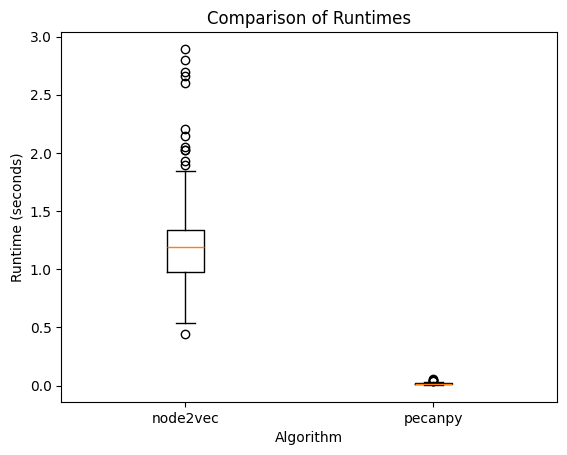

t-statistic:	 25.918349676771275
p-value:	 7.529257659984512e-66


In [7]:
# Creating a boxplot with the previously recorded data
data = pd.read_csv("data.csv")
plt.boxplot([data['node2vec runtimes'], data['PecanPy runtimes']],
            labels=['node2vec', 'pecanpy'])
plt.xlabel('Algorithm')
plt.ylabel('Runtime (seconds)')
plt.title('Comparison of Runtimes')
plt.show()

# Performing the one-tailed t-test
t_stat, p_value = ttest_ind(data['node2vec runtimes'], data['PecanPy runtimes'], alternative='greater')
print("t-statistic:\t", t_stat)
print("p-value:\t", p_value)

## Conclusion
Given that the t-test resulted in a p-value much lower than our originally stated alpha value of 0.05, we can reject the null hypothesis and conclude that the time required for the *PecanPy* implementation is significantly lower than the *node2vec* implementation. Therefore, we have evidence to suggest that **the newer *PecanPy* implementation is an *improvement* over the original *node2vec* implementation**